In [1]:
import sys
sys.path.append('./../')
from pyNN.random import RandomDistribution, NumpyRNG
from pyNN import neuron
import pyNN.space as space
import pyNN
import pyNN.neuron as sim
import numpy as np
from pyNN.utility.plotting import Figure, Panel
from pyNN.space import Grid2D, RandomStructure, Sphere
import matplotlib.pyplot as plt
from neuroml import Morphology, Segment, Point3DWithDiam as P
from pyNN.morphology import NeuroMLMorphology, NeuriteDistribution, Morphology as Morph, IonChannelDistribution
from pyNN.neuron.morphology import uniform, random_section, random_placement, at_distances, apical_dendrites, dendrites, centre
from pyNN.parameters import IonicSpecies
from pyNN.standardmodels import StandardIonChannelModel, build_translations, StandardCellType
from pyNN.standardmodels.cells import SpikeSourceGamma
from pyNN.neuron import NativeCellType
import shutil
import os
from neuron import h, nrn, hclass
from pyNN.utility.build import compile_nmodl
from pyNN.standardmodels.cells import MultiCompartmentNeuron as mc
import platform
from pyNN.neuron.cells import RandomSpikeSource
import src.Classes as Classes
import src.funçoes as funçoes

c:\Users\rebek\Modelo-Motoneuronio\modelpynn\lib\site-packages\pyNN\neuron\__init__.py:14: UserWarning: mpi4py not available
  warnings.warn("mpi4py not available")


In [2]:
if platform.system() == 'Linux':
    shutil.copyfile('./../src/mn.mod','./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.mod')
    shutil.copyfile('./../src/gammapointprocess.mod','./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/gammapointprocess.mod')
    compile_nmodl('./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/')
    h.nrn_load_dll('./../modelpynn/lib/python3.10/site-packages/pyNN/neuron/nmodl/mn.o')
if platform.system() == 'Windows':
    shutil.copyfile('../src/mn.mod','../modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.mod')
    shutil.copyfile('../src/gammapointprocess.mod','../modelpynn/Lib/site-packages/pyNN/neuron/nmodl/gammapointprocess.mod')
    compile_nmodl('../modelpynn/Lib/site-packages/pyNN/neuron/nmodl')
    h.nrn_load_dll('modelpynn/Lib/site-packages/pyNN/neuron/nmodl/mn.o')
    


nrnivmodl found at c:\neuron\bin\nrnivmodl
Successfully compiled NEURON extensions.


In [3]:
sim.setup(timestep=0.05)

n = 100
somas = funçoes.create_somas(n)
dends = funçoes.create_dends(n,somas)




In [4]:
cell_type = Classes.cell_class(
    morphology= funçoes.soma_dend(somas, dends) ,
    cm=1,    # mF / cm**2
    Ra=0.070, # ohm.mm
    ionic_species={"na": IonicSpecies("na", reversal_potential=50),
                   "ks": IonicSpecies("ks", reversal_potential=-80),
                   "kf": IonicSpecies("kf", reversal_potential=-80)
                  },
    pas_soma = {"conductance_density": uniform('soma', 7e-4), "e_rev":-70},
    pas_dend = {"conductance_density": uniform('dendrite', 7e-4), "e_rev":-70},
    na = {"conductance_density": uniform('soma', 10), "vt":list(np.linspace(-57.65, -53,100))},
    kf = {"conductance_density": uniform('soma', 1), "vt":list(np.linspace(-57.65, -53,100))},
    ks = {"conductance_density": uniform('soma', 0.5), "vt":list(np.linspace(-57.65, -53,100))},

    syn={
        "locations": centre('dendrite'),
        "e_syn": 0,
        "tau_syn": 0.6},  
)

In [5]:
cells = sim.Population(n, cell_type, initial_values={'v': list(-70*np.ones(n))})

In [6]:
np.random.seed(26278342)
spike_source = sim.Population(400, Classes.SpikeSourceGammaStart(alpha=1)) 
                                                        #start=RandomDistribution('uniform', [0, 3.0], rng=NumpyRNG(seed=4242))))
syn = sim.StaticSynapse(weight=0.6, delay=0.2)
input_conns = sim.Projection(spike_source, cells, 
                             sim.FixedProbabilityConnector(0.3, location_selector='dendrite'), 
                             syn, receptor_type="syn")

In [7]:
spike_source.record('spikes')
cells.record('spikes')
cells[0:2].record('v', locations=('dendrite','soma'))
cells[0:2].record(('na.m', 'na.h'), locations='soma')
cells[0:2].record(('kf.n'), locations='soma')
cells[0:2].record(('ks.p'), locations='soma')


In [8]:
sim.run(1000, callbacks=[Classes.SetRate(spike_source, cells)])

999.9999999993644

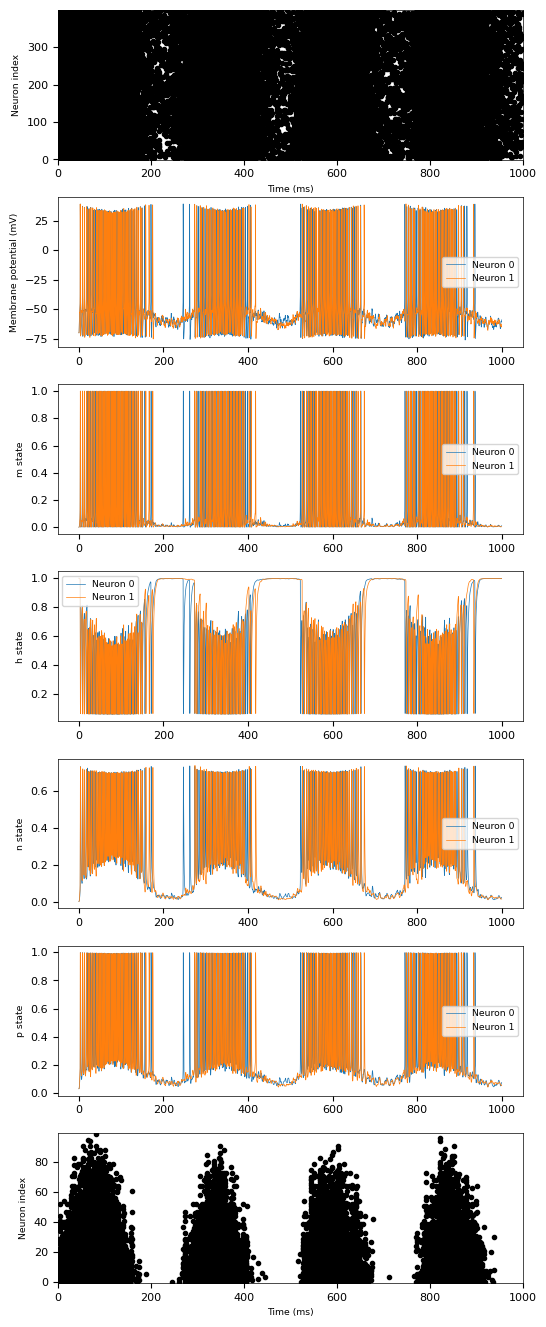

In [9]:
figure_filename = 'teste.png'
data_source = spike_source.get_data().segments[0]
data = cells.get_data().segments[0]
vm = data.filter(name="soma.v")[0]
m = data.filter(name="soma.na.m")[0]
h = data.filter(name="soma.na.h")[0]
n = data.filter(name="soma.kf.n")[0]
p = data.filter(name="soma.ks.p")[0]
# ina = data.filter(name="soma.na.ina")[0]
# ik = data.filter(name="ik")[0]

# gsyn = data.filter(name="gsyn_exc")[0]
Figure(
    Panel(data_source.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
    Panel(vm, ylabel="Membrane potential (mV)", xticks=True, yticks=True),
    Panel(m, ylabel="m state", xticks=True, yticks=True),
    Panel(h, ylabel="h state", xticks=True, yticks=True),
    Panel(n, ylabel="n state", xticks=True, yticks=True),
    Panel(p, ylabel="p state", xticks=True, yticks=True),
    # Panel(ina, ylabel="i_na (mA)", xticks=True, yticks=True),
    # Panel(ik, ylabel="i_k (mA)", xticks=True, yticks=True),
    
    # Panel(gsyn, ylabel="Synaptic conductance (uS)"),
    Panel(data.spiketrains, xlabel="Time (ms)", xticks=True, yticks=True),
).save(figure_filename)


In [10]:
data.spiketrains[10].as_array()


array([  3.35,   8.2 ,  12.6 ,  17.95,  22.65,  28.3 ,  33.6 ,  38.2 ,
        41.35,  44.55,  48.  ,  51.05,  54.2 ,  57.75,  61.  ,  64.2 ,
        67.2 ,  70.55,  73.3 ,  76.5 ,  79.95,  83.65,  87.4 ,  90.6 ,
        93.7 ,  97.15, 100.25, 103.95, 107.3 , 110.75, 114.75, 118.4 ,
       122.35, 126.55, 129.9 , 133.95, 137.95, 145.2 , 149.95, 174.6 ,
       269.65, 284.2 , 294.75, 298.9 , 305.3 , 308.85, 312.3 , 316.15,
       319.45, 322.55, 325.6 , 328.8 , 332.25, 335.8 , 339.  , 342.1 ,
       345.6 , 349.1 , 353.05, 356.55, 359.75, 363.45, 367.35, 371.3 ,
       375.75, 380.05, 384.6 , 389.6 , 394.7 , 399.15, 405.9 , 528.1 ,
       532.9 , 537.6 , 543.1 , 550.15, 553.65, 557.65, 562.3 , 567.05,
       570.  , 573.  , 576.85, 580.45, 584.2 , 588.  , 590.85, 594.2 ,
       597.4 , 601.65, 605.4 , 610.65, 614.  , 618.45, 624.5 , 628.75,
       632.5 , 636.45, 640.15, 645.05, 649.35, 674.85, 773.45, 786.5 ,
       791.4 , 794.9 , 798.8 , 806.9 , 811.  , 814.8 , 819.  , 822.15,
      

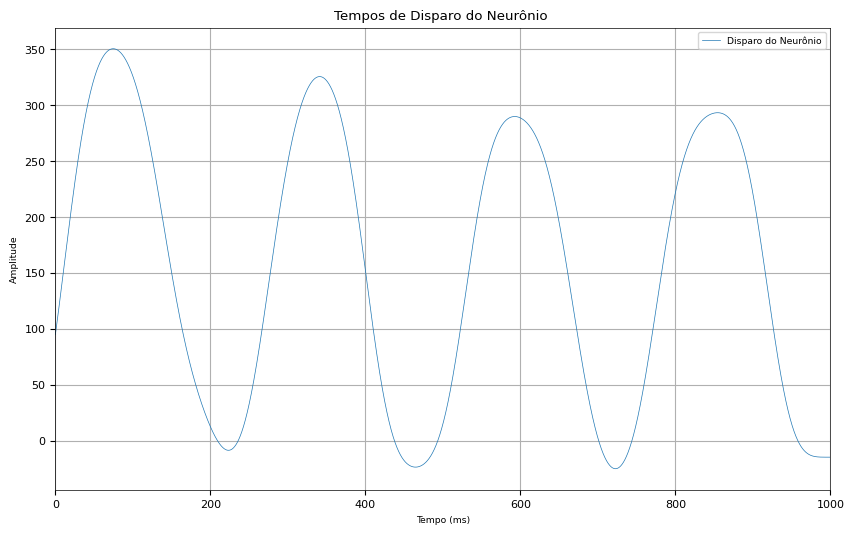

C:\Users\rebek\AppData\Local\Temp\ipykernel_62892\2884122341.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


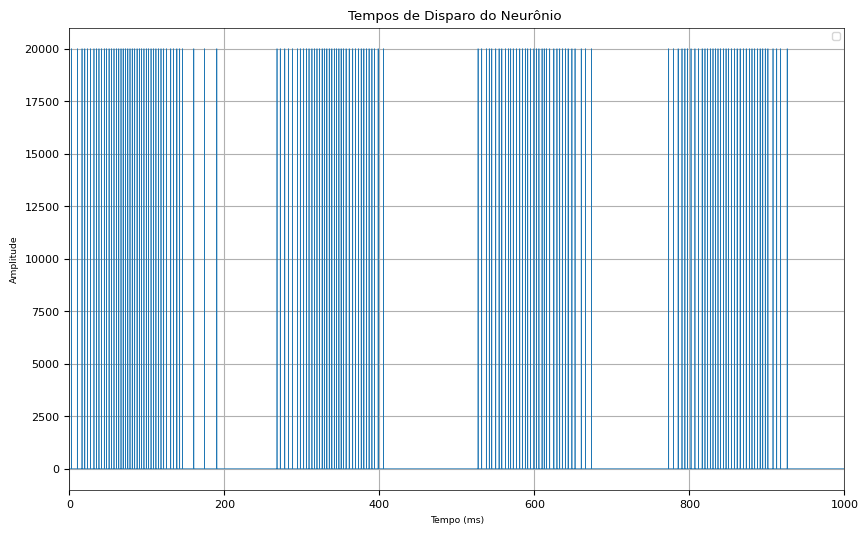

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Array com os tempos de disparo do neurônio
tempos_neuronios = data.spiketrains[5].as_array()

# Criação de uma função delta para cada tempo de disparo
delta_t = 0.00005
t = np.arange(0, 1000, delta_t*1000)
impulso_dirac = np.zeros_like(t)

# Adiciona o impulso de Dirac em cada tempo de disparo do neurônio
for tempo in tempos_neuronios:
    idx = np.argmin(np.abs(t - tempo)) #encontra o índice mais próximo do tempo de disparo no array de tempo t
    impulso_dirac[idx] = 1 / delta_t 

# Filtro Butterworth de 2ª ordem com frequência de corte normalizada (0.1)
b, a = signal.butter(4, 0.001)

# Aplicação do filtro usando o método de Gustafsson
filtered_impulso = signal.filtfilt(b, a, impulso_dirac)

# Plotar a representação do impulso de Dirac
plt.figure(figsize=(10, 6))
plt.plot(t, filtered_impulso, label="Disparo do Neurônio")
plt.title("Tempos de Disparo do Neurônio ")
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude")
plt.xlim(0, 1000)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(t,impulso_dirac)
plt.title("Tempos de Disparo do Neurônio ")
plt.xlabel("Tempo (ms)")
plt.ylabel("Amplitude")
plt.xlim(0, 1000)
plt.grid(True)
plt.legend()
plt.show()


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def plot_disparos_neuronios(spiketrains, neuronio, delta_t=0.00005, filtro_ordem=4, freq_corte=0.001, tempo_max=1000):
    """
    Função que gera o impulso de Dirac para os tempos de disparo de um neurônio e aplica um filtro Butterworth.
    
    Parâmetros:
        spiketrains (list): Lista com os trens de disparo de neurônios.
        neuronio (int): Índice do neurônio a ser processado.
        delta_t (float): Intervalo de tempo. Padrão é 0.00005.
        filtro_ordem (int): Ordem do filtro Butterworth. Padrão é 4.
        freq_corte (float): Frequência de corte normalizada para o filtro Butterworth. Padrão é 0.001.
        tempo_max (float): Tempo máximo para o eixo x (em milissegundos). Padrão é 1000.
    """
    
    # Array com os tempos de disparo do neurônio
    tempos_neuronios = spiketrains[neuronio].as_array()

    # Criação do vetor de tempo
    t = np.arange(0, tempo_max, delta_t * 1000)
    impulso_dirac = np.zeros_like(t)

    # Adiciona o impulso de Dirac em cada tempo de disparo do neurônio
    for tempo in tempos_neuronios:
        idx = np.argmin(np.abs(t - tempo))  # encontra o índice mais próximo do tempo de disparo
        impulso_dirac[idx] = 1 / delta_t

    # Filtro Butterworth
    b, a = signal.butter(filtro_ordem, freq_corte)

    # Aplicação do filtro
    filtered_impulso = signal.filtfilt(b, a, impulso_dirac)

    # Plotar os resultados
    plt.figure(figsize=(10, 6))
    plt.plot(t, filtered_impulso, label="Disparo do Neurônio (Filtrado)")
    plt.title("Tempos de Disparo do Neurônio (Filtrado)")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("Amplitude")
    plt.xlim(0, tempo_max)
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(t, impulso_dirac, label="Disparo do Neurônio (Impulso de Dirac)")
    plt.title("Tempos de Disparo do Neurônio (Impulso de Dirac)")
    plt.xlabel("Tempo (ms)")
    plt.ylabel("Amplitude")
    plt.xlim(0, tempo_max)
    plt.grid(True)
    plt.legend()
    plt.show()


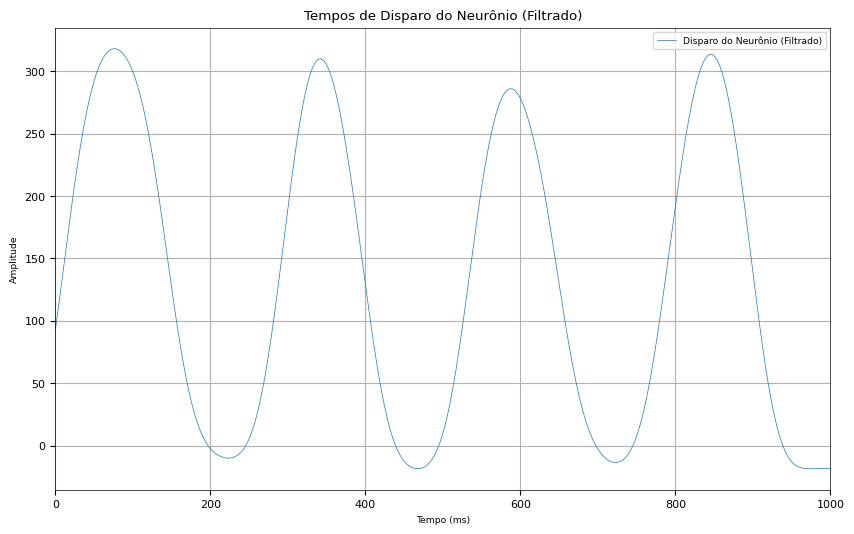

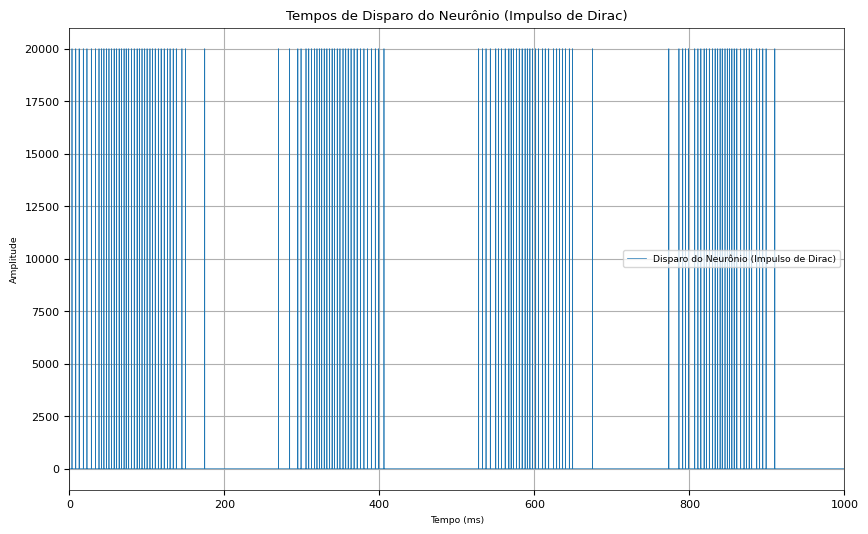

In [14]:
plot_disparos_neuronios(data.spiketrains, neuronio=10)